# SVM - Kernel

* Potentielle Kernel: RBF, Polynomial, Spectral Mixture Kernel, Sigmoid Kernel
* Calculate SVM using dual decision functions
* Thus: Model theta has as many parameters as examples.
* Kernel function: Measure of similarity between instances.
* Hence: How similar is instance x to each other trainings instance?
* Derivation from the primal into the dual form is necessary (lecture).

Optimization criterion of the dual SVM:

$$
max_{\beta} \sum_{i=1}^n \beta_i - \frac{1}{2} \sum_{i,j=1}^n \beta_i \beta_j y_i y_j k(x_i,x_j) \text{, such that } 0 \leq \beta_i \leq \lambda
$$

* Optimization over parameters beta
* Sparse solution (solution of a problem where most of the elements are zero)
* Reason: Samples only appear as pairwise inner products.
* Sparsity desired property because it often leads to simpler, more interpretable models.
* QPP - Quadratic programming problem

Dual from of the decision function:

$$
f_{\beta}(x)= \sum_{x_i\in SV} \beta_i y_i k(x_i, x)
$$

(SV = Support Vectors)

* Only the support vectors (points with non-zero beta_i) contribute to the decision function.
* Decision function is weighted sum over the support vectors.
* Decides the class based on the sign of this sum.


**Hint:**

This code is a implementation of kernelized empirical risk minimization that aligns with the SVM concepts but uses gradient descent instead of directly solving the dual problem via quadratic programming.

## Data Import

In [10]:
from scipy.io import loadmat
from sklearn.model_selection import ParameterGrid
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from svm_helper import SvmHelper
from dataset import BaseDataset
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

file_path = "../../data/laser.mat"
mat_dict = loadmat(file_path)

dataset = BaseDataset(mat_dict, "X", "Y")

Checking path: ../../data_split_indices.pkl
Path exists: True


In [ ]:
def send_imessage(phone_number, message):
    """Send an iMessage to the given phone number using AppleScript."""
    applescript_command = f'''
    tell application "Messages"
        set targetService to 1st account whose service type = iMessage
        set targetBuddy to buddy "{phone_number}" of targetService
        send "{message}" to targetBuddy
    end tell
    '''
    os.system(f'osascript -e \'{applescript_command}\'')

def put_mac_to_sleep():
    """Puts the Mac to sleep using a system command."""
    os.system("sudo pmset sleepnow")

## Grid-Search

In [11]:
param_grid = {
    'epsilon': [1e-4, 1e-5, 1e-6],
    'alpha_0': [0.001, 0.01, 0.1, 1],
    'lambda_value': [0.001, 0.01, 0.1, 1.0, 10.0],
    'decay': [0.001, 0.01, 0.1, 0.9]
}

kernel_param_grid = {
    'polynomial': {
        'degree': [2, 3, 4],
        'kernel_alpha': [1, 0.1],
        'c': [0, 1]
    },
    'rbf': {
        'gamma': [0.001, 0.01, 0.1, 1.0]
    },
    'dtw': {} 
}

def train_model_with_params(params, kernel_function, kernel_params=None, verbose=False):
    """Train the model with the selected kernel and parameters."""
    
    if kernel_params is None:
        kernel_params = {}

    theta = SvmHelper.regularised_kernel_erm_batch(
        inputs=dataset.train_inputs,
        labels=dataset.train_labels,
        kernel_function=kernel_function,
        max_iterations=100,
        epsilon=params['epsilon'], 
        alpha=params['alpha_0'], 
        lbda=params['lambda_value'],
        decay=params['decay'],
        **kernel_params  
    )

    predictions = SvmHelper.predict_kernel(
        theta=theta,
        kernel_function=kernel_function,
        test_inputs=dataset.test_inputs,
        train_inputs=dataset.train_inputs
    )

    accuracy = accuracy_score(dataset.test_labels, predictions)

    if verbose:
        print(f"Accuracy with current params: {accuracy}")
    
    return accuracy

def create_accuracy_plot(accuracies, selected_kernel):

    iterations =  range(1, len(accuracies) + 1)

    plt.plot(iterations, accuracies, label=f"{selected_kernel} - Accuracy", color="green")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title(f"{selected_kernel} - Accuracy")
    plt.grid(True)
    
    plt.show()

## DTW Kernel

DTW = Dynamic Time Warping - A way to measure the similarity between two sequences, which vary in length or be misaligned in time.

Given a metric $d: X \times X \rightarrow \mathbb{R}_{\geq 0}$ on the input space $X$, the family of *DTW Kernels* is given as:

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

* Distance measure $d_{DTW}$ is heart of DTW and is computed by a recursive function $\gamma(i, j)$.
* $\gamma(i, j)$ builds up the minimal distance between the sequences uop to position i,j.
* Computation of DTW distance: Dynamic programming with a $(|x|+1) \times (|x'|+1)$ grid.

**Note:**

$$
d_{DTW}(x,x´;d) = \gamma(\mid x\mid,\mid x´\mid )
$$

$$ 
\gamma(i, j) = \begin{cases} d(x_i, x_j') + \min\left(\gamma(i-1, j-1), \gamma(i-1, j), \gamma(i, j-1)\right) & (1 \leq i \leq |x|, \, 1 \leq j \leq |x'|), \\ 
\infty & i = 0 \vee j = 0, \\
0 & (i, j) = (0, 0). \end{cases}
$$

* $\gamma(i, j)$ is calculated all possible combinations of $j$ and $i$, starting from $\gamma(0, 0)$ up to $\gamma(\mid x\mid,\mid x´\mid )$

Table:

|     | 0   | 2   | 4   | 6   |
|-----|-----|-----|-----|-----|
| 0   | 0   | ∞   | ∞   | ∞   |
| 1   | ∞   | 1   | 9   | 25  |
| 3   | ∞   | 2   | 2   | 14  |
| 4   | ∞   | 5   | 2   | 8   |


$$ \gamma(1, 1) = (1 - 2)^2 + \min(\gamma(0, 0), \gamma(0, 1), \gamma(1, 0)) = 1 + 0 = 1 $$
$$\gamma(2, 2) = (3 - 4)^2 + \min(\gamma(1, 1), \gamma(1, 2), \gamma(2, 1)) = 1 + 1 = 2 $$

The final DTW distance is:

$$
\gamma(3, 3) = 8
$$






<img src="../../images/DTW_dynamic_programming.png" alt="Image" style="width:30%">

Figure A: Example of a DTW $\gamma(i, j)$.



Best parameters found: {'alpha_0': 0.001, 'decay': 1, 'epsilon': 1e-05, 'lambda_value': 1.0}
Best score: 1.0


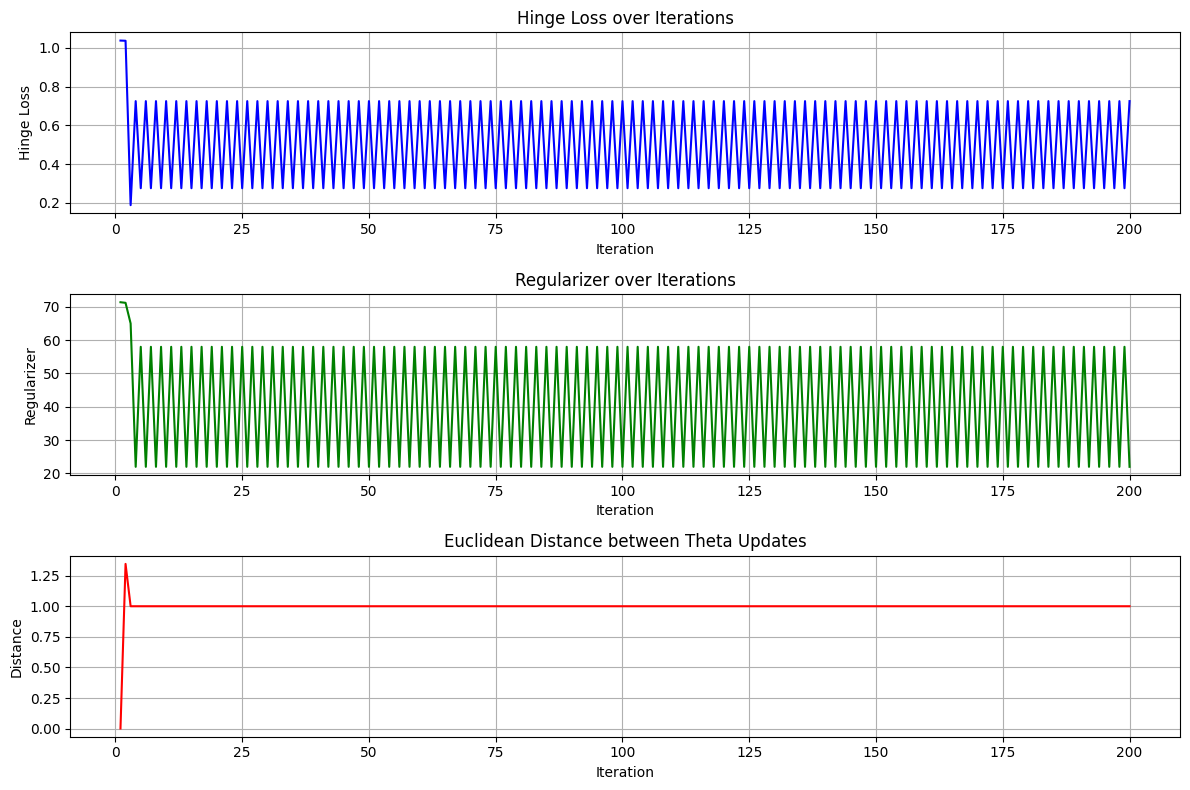

accuracy = 0.925


In [12]:
try:


    selected_kernel = 'dtw'

    best_params = None
    best_score = 0.0
    dtw_scores_history = []

    for model_params in ParameterGrid(param_grid):
        if selected_kernel in kernel_param_grid:
            for kernel_params in ParameterGrid(kernel_param_grid[selected_kernel]):
                if selected_kernel == 'dtw':
                    kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
                elif selected_kernel == 'polynomial':
                    kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
                            input, 
                            input_copy, 
                            alpha=kernel_params['kernel_alpha'], 
                            degree=kernel_params['degree'],
                                c=kernel_params['c'] 
                    )
                elif selected_kernel == 'rbf':
                    kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(input, input_copy, **kernel_params)
                
                score = train_model_with_params(model_params, kernel_function=kernel_function, kernel_params=kernel_params)
                dtw_scores_history.append(score)
                if score > best_score:
                    best_score = score
                    best_params = {**model_params, **kernel_params}  

    print("Best parameters found:", best_params)
    print("Best score:", best_score)

    create_accuracy_plot(dtw_scores_history, selected_kernel)

    model_specific_params = {
        'alpha': best_params['alpha_0'],
        'epsilon': best_params['epsilon'],
        'lbda': best_params['lambda_value'],
        'decay': best_params['decay']
    }

    if selected_kernel == 'dtw':
        kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
    elif selected_kernel == 'polynomial':
        kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
            input, input_copy, 
            alpha=best_params['kernel_alpha'], 
            degree=best_params['degree'], 
            c=best_params['c']
        )
    elif selected_kernel == 'rbf':
        kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(
            input, input_copy, 
            gamma=best_params['gamma']
        )

    dtw_theta = SvmHelper.regularised_kernel_erm_batch(
        inputs=dataset.train_inputs,
        labels=dataset.train_labels,
        kernel_function=kernel_function, 
        max_iterations=200,
        alpha=model_specific_params['alpha'], 
        epsilon=model_specific_params['epsilon'], 
        lbda=model_specific_params['lbda'],
        decay=model_specific_params['decay'],
        verbose=False,
        figure=True
    )

    dtw_predictions = SvmHelper.predict_kernel(theta=dtw_theta, kernel_function=kernel_function, test_inputs=dataset.test_inputs, train_inputs=dataset.train_inputs)
    dtw_accuracy = accuracy_score(dataset.test_labels, dtw_predictions)

    print(f'accuracy = {dtw_accuracy}')

    send_imessage("+4901742064864", f"{selected_kernel} script finished successfully with accuracy: {rbf_accuracy}")

except Exception as e:
    print(f"An error occurred: {e}")
    
    send_imessage("+4901742064864", f"An error occurred in {selected_kernel} kernel: {e}")
    
    put_mac_to_sleep()

## Polynomial Kernel

$$
k_{poly}(x,x´) = (\alpha*x^Tx´+c)^d
$$

- $\alpha$ scaling factor
- $c$ constant that allows the model to shift the boundary
- $d$ degree of the polynomial


In [13]:
try:
    selected_kernel = 'polynomial'  

    best_params = None
    best_score = 0.0
    poly_scores_history = []

    for model_params in ParameterGrid(param_grid):
        if selected_kernel in kernel_param_grid:
            for kernel_params in ParameterGrid(kernel_param_grid[selected_kernel]):
                if selected_kernel == 'dtw':
                    kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
                elif selected_kernel == 'polynomial':
                    kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
                            input, 
                            input_copy, 
                            alpha=kernel_params['kernel_alpha'], 
                            degree=kernel_params['degree'],
                            c=kernel_params['c'] 
                    )
                elif selected_kernel == 'rbf':
                    kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(input, input_copy, **kernel_params)
                
                score = train_model_with_params(model_params, kernel_function=kernel_function, kernel_params=kernel_params)
                poly_scores_history.append(score)
                if score > best_score:
                    best_score = score
                    best_params = {**model_params, **kernel_params}


    print("Best parameters found:", best_params)
    print("Best score:", best_score)

    create_accuracy_plot(poly_scores_history, selected_kernel)

    model_specific_params = {
        'alpha': best_params['alpha_0'],
        'epsilon': best_params['epsilon'],
        'lbda': best_params['lambda_value'],
        'decay': best_params['decay']
    }


    if selected_kernel == 'dtw':
        kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
    elif selected_kernel == 'polynomial':
        kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
            input, input_copy, 
            alpha=best_params['kernel_alpha'], 
            degree=best_params['degree'], 
            c=best_params['c']
        )
    elif selected_kernel == 'rbf':
        kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(
            input, input_copy, 
            gamma=best_params['gamma']
        )

    poly_theta = SvmHelper.regularised_kernel_erm_batch(
        inputs=dataset.train_inputs,
        labels=dataset.train_labels,
        kernel_function=kernel_function, 
        max_iterations=200,
        alpha=model_specific_params['alpha'], 
        epsilon=model_specific_params['epsilon'], 
        lbda=model_specific_params['lbda'],
        decay=model_specific_params['decay'],
        verbose=False,
        figure=True
    )

    poly_predictions = SvmHelper.predict_kernel(theta=poly_theta, kernel_function=kernel_function, test_inputs=dataset.test_inputs, train_inputs=dataset.train_inputs)
    poly_accuracy = accuracy_score(dataset.test_labels, poly_predictions)

    print(f'accuracy = {poly_accuracy}')
    send_imessage("+4901742064864", f"{selected_kernel} script finished successfully with accuracy: {rbf_accuracy}")

except Exception as e:
    print(f"An error occurred: {e}")
    
    send_imessage("+4901742064864", f"An error occurred in {selected_kernel} kernel: {e}")
    
    put_mac_to_sleep()

TypeError: svm_helper.SvmHelper.regularised_kernel_erm_batch() got multiple values for keyword argument 'alpha'

## RBF Kernel

RBF - Radial Basis Function

$$
k_{RBF}(x,x´) = e^{-\lambda *\| x-x´\|^2 }
$$

- $\lambda$ controls width of the Gaussian

In [ ]:
try:  
    selected_kernel = 'rbf' 

    best_params = None
    best_score = 0.0
    rbf_scores_history = []

    for model_params in ParameterGrid(param_grid):
        if selected_kernel in kernel_param_grid:
            for kernel_params in ParameterGrid(kernel_param_grid[selected_kernel]):
                if selected_kernel == 'dtw':
                    kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
                elif selected_kernel == 'polynomial':
                    kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
                            input, 
                            input_copy, 
                            alpha=kernel_params['kernel_alpha'], 
                            degree=kernel_params['degree'],
                            c=kernel_params['c'] 
                    )
                elif selected_kernel == 'rbf':
                    kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(input, input_copy, **kernel_params)
                
                score = train_model_with_params(model_params, kernel_function=kernel_function, kernel_params=kernel_params)
                rbf_scores_history.append(score)
                if score > best_score:
                    best_score = score
                    best_params = {**model_params, **kernel_params} 

    print("Best parameters found:", best_params)
    print("Best score:", best_score)

    create_accuracy_plot(rbf_scores_history, selected_kernel)

    model_specific_params = {
        'alpha': best_params['alpha_0'],
        'epsilon': best_params['epsilon'],
        'lbda': best_params['lambda_value'],
        'decay': best_params['decay']
    }


    if selected_kernel == 'dtw':
        kernel_function = lambda input, input_copy: SvmHelper.dtw_kernel(input, input_copy)
    elif selected_kernel == 'polynomial':
        kernel_function = lambda input, input_copy: SvmHelper.polynomial_kernel(
            input, input_copy, 
            alpha=best_params['kernel_alpha'], 
            degree=best_params['degree'], 
            c=best_params['c']
        )
    elif selected_kernel == 'rbf':
        kernel_function = lambda input, input_copy: SvmHelper.rbf_kernel(
            input, input_copy, 
            gamma=best_params['gamma']
        )

    rbf_theta = SvmHelper.regularised_kernel_erm_batch(
        inputs=dataset.train_inputs,
        labels=dataset.train_labels,
        kernel_function=kernel_function, 
        max_iterations=200,
        alpha=model_specific_params['alpha'], 
        epsilon=model_specific_params['epsilon'], 
        lbda=model_specific_params['lbda'],
        decay=model_specific_params['decay'],
        verbose=False,
        figure=True
    )

    rbf_predictions = SvmHelper.predict_kernel(theta=rbf_theta, kernel_function=kernel_function, test_inputs=dataset.test_inputs, train_inputs=dataset.train_inputs)
    rbf_accuracy = accuracy_score(dataset.test_labels, rbf_predictions)

    print(f'accuracy = {rbf_accuracy}')

    send_imessage("+4901742064864", f"{selected_kernel} script finished successfully with accuracy: {rbf_accuracy}")

except Exception as e:
    print(f"An error occurred: {e}")
    
    send_imessage("+4901742064864", f"An error occurred in {selected_kernel} kernel: {e}")
    
    put_mac_to_sleep()

In [ ]:

finally:
    os.system('say "Training is ready."')
    put_mac_to_sleep()